In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.stats_utils import load_statistics

from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_comparison, barplot_comparison
from cdi.util.analysis.logs import collate_stats
from cdi.util.analysis.eval import (compute_avg_loglikelihood_w_std_err,
                                    compute_param_error)

## Analysis setup

### Global settings

In [6]:
data_name = 'flows_uci'
flow_data = 'miniboone'
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'
log_path_template_val = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs_{{}}/{{}}'
log_path_base = f'../../trained_models/{data_name}/learning_experiments'


## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_val(group, model, seed, val_ckpt, filename):
    path = log_path_template_val.format(group, model, seed, val_ckpt, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_val(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        for ckpt in val_ckpts[name]:
            name_i = f'{name} val{ckpt}'
            ckpt_name = f'{ckpt}_cust'
            try:
                stats[name_i] = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
    return stats

def read_suite_stats_val2(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        stats_i = defaultdict(list)
        for ckpt in val_ckpts[name]:
            try:
                ckpt_name = f'{ckpt}_cust'
                stat = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
                for k, v in stat.items():
                    # Append the last element from each key
                    stats_i[k].append(v[-1])
                stats_i['epoch'].append(ckpt)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
        stats[name] = stats_i
    return stats

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


def ma(a, ws=10):
    return np.convolve(a[::-1], np.ones(ws)/ws, mode='valid')[::-1]

In [9]:
# ggplot
colors = ['#000000', '#E24A33', '#988ED5', '#34b9bd', '#FBC15E', '#348ABD', '#FFB5B8', '#777777', '#8EBA42',]

## Learning curve analysis

### Likelihood analysis


In [12]:
suite = {
    'Complete': f'rqcspline_{flow_data}_complete_data',
    'Complete subsampled': f'rqcspline_{flow_data}_complete_data_subsampled',
#     'Mean': f'rqcspline_{flow_data}_mean_baseline',
#     'Emp.': f'rqcspline_{flow_data}_empirical_sample_baseline',
# # #     'VGI anneal too fast': f'rqcspline_{flow_data}_svar_cdi_annealed100steps',
# # #     'VGI no var anneal': f'rqcspline_{flow_data}_svar_cdi_novaranneal',
# # #     'VGI': f'rqcspline_{flow_data}_svar_cdi_annealvarlr',
#     'VGI lrelu k5 nc10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m1_g5',
# # #     'VGI relu k5 nc10': f'rqcspline_{flow_data}_svar_cdi_relu_k5_nc10_m1_g5',
# # #     'VGI lrelu k5 nc5': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc5_m1_g5',
#     'VGI lrelu k10 nc10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k10_nc10_m1_g5',
# #     'VGI lrelu k5 nc10 m2': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m2_g5',
#     'PLMCMC old': f'old_2/rqcspline_{flow_data}_plmcmc',
#     'PLMCMC persistent k5 g5': f'rqcspline_{flow_data}_plmcmc_persistent',
#     'PLMCMC persistent k10 g5': f'rqcspline_{flow_data}_plmcmc_persistent_k10',
#     'PLMCMC persistent k5 g10': f'rqcspline_{flow_data}_plmcmc_persistent_g10',
#     'PLMCMC pstd0.1 rprob0.2': f'rqcspline_{flow_data}_plmcmc_pstd01_rprob02',
#     'PLMCMC period20 switch20': f'rqcspline_{flow_data}_plmcmc_per20_switch20',
#     'PLMCMC noclamp': f'rqcspline_{flow_data}_plmcmc_noclamp',
#     'PLMCMC orig': f'rqcspline_{flow_data}_plmcmc_orig',
#     'PLMCMC pstd0.001': f'rqcspline_{flow_data}_plmcmc_pstd0001',
#     'PLMCMC notapproxkernel': f'rqcspline_{flow_data}_plmcmc_notapproxkernel',
#     'PLMCMC remove aux term': f'rqcspline_{flow_data}_plmcmc_removeauxterm',
#     'PLMCMC pstd0.0001 notapproxkernel ast0.01': f'rqcspline_{flow_data}_plmcmc_pstd00001_notapproxkernel_astd001',
#     'PLMCMC pstd0.001 notapproxkernel Gx2': f'rqcspline_{flow_data}_plmcmc_pstd0001_gx2_notapproxkernel',
#     'PLMCMC no jacob terms': f'rqcspline_{flow_data}_plmcmc_nojacobterm',
#     'PLMCMC pstd0.001 remove aux term': f'rqcspline_{flow_data}_plmcmc_pstd0001_removeauxterm',
#     'PLMCMC pstd0.1 remove aux term': f'rqcspline_{flow_data}_plmcmc_pstd01_removeauxterm',
#     'PLMCMC pstd0.001': f'rqcspline_{flow_data}_plmcmc_pstd0001',
#     'PLMCMC pstd0.1': f'rqcspline_{flow_data}_plmcmc_pstd01',
#     'PLMCMC persistent2': f'rqcspline_{flow_data}_plmcmc_persistent2',
#     'PLMCMC persistent2 g10': f'rqcspline_{flow_data}_plmcmc_persistent2_g10',
#     'PLMCMC g1000': f'rqcspline_{flow_data}_plmcmc_g1000',
#     'PLMCMC g(500,2000,3000)': f'old_2/rqcspline_{flow_data}_plmcmc_g500_2000_3000',
#     'PLMCMC g(500,2000,3000) short': f'rqcspline_{flow_data}_plmcmc_g500_2000_3000_short',
#     'PLMCMC g(500,2000,3000) short2': f'rqcspline_{flow_data}_plmcmc_g500_2000_3000_short2',
    
    
#     ## 83%
# #     'VGI lrelu k5 nc10 d10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m1_g5_d10',
# #     'VGI lrelu k5 nc10 d15': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m1_g5_d15',
#     'VGI lrelu k5 nc10 d20': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m1_g5',
# #     'VGI lrelu k10 nc10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k10_nc10_m1_g5',
# #     'VGI lrelu k20 nc10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k20_nc10_m1_g5',
    
#     'VGI lrelu k5 nc10 m4': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m4_g5',
#     'VGI lrelu k5 nc10 m7': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m7_g5',
# #     'VGI lrelu k5 nc10 m7 arch2': f'rqcspline_{flow_data}_svar_cdi_lrelu_k5_nc10_m7_g5_arch2',
#     'VGI lrelu k20 nc10 long': f'rqcspline_{flow_data}_svar_cdi_lrelu_k20_nc10_m1_g5_long',
#     'VGI lrelu k40 nc10 long': f'rqcspline_{flow_data}_svar_cdi_lrelu_k40_nc10_m1_g5_long',
#     'VGI lrelu k40 nc10 varlr1e-4': f'rqcspline_{flow_data}_svar_cdi_lrelu_k40_nc10_m1_g5_varlr1e-4',
#     'VGI lrelu k40 nc10 arch2': f'rqcspline_{flow_data}_svar_cdi_lrelu_k40_nc10_m1_g5_arch2',
# #     'VGI lrelu k100 nc10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k100_nc10_m1_g5_long',
#     'VGI lrelu k40 nc10 g10': f'rqcspline_{flow_data}_svar_cdi_lrelu_k40_nc10_m1_g10',
    
#     'VGI': f'rqcspline_{flow_data}_svar_cdi',
#     'VGI (RQ-cond)': f'rqcspline_{flow_data}_rqsvar_cdi_nopretrain',
#     'VGI CH (RQ-cond)': f'rqcspline_{flow_data}_chrqsvar_cdi',
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
    'VGI (longrun)': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss_longrun',
#     'VGI (RQ-cond) uncondgauss nopretrain': f'rqcspline_{flow_data}_rqsvar_cdi_nopretrain_uncondgauss',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
#     'PLMCMC k10': f'rqcspline_{flow_data}_plmcmc_k10',
    
    
    'Complete (AR)': f'rqarspline_{flow_data}_complete_data',
#     'Complete (AR) lr1e-4': f'rqarspline_{flow_data}_complete_data_lr1e-4',
#     'VGI longrun': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss_longrun',
}

suite_val = {

}

val_ckpts = {

}

<IPython.core.display.Javascript object>


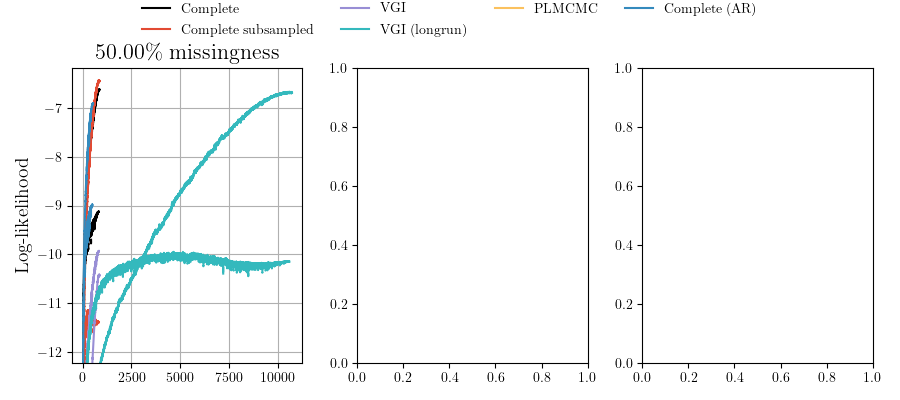

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
axes = axes.flatten()
# axes = [axes]
# gs = [1, 2, 3, 4, 5]
# gs = [1, 3, 5]
# gs = [1, 3]
gs = [3]
# gs = [5]
for i, g in enumerate(gs):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    
    for exp, stat in stats.items():
        if 'VGI' in exp:
            stat['train_log_lik'] = np.array(stat['train_log_lik']) + np.array(stat['train_entropy'])
        stat['cum_train_time'] = np.cumsum(stat['train_time'])

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, 2):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    if i in (2, 3):
        xlabel='Epoch'
    else:
        xlabel=None
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
#                     x_metric_key='cum_train_time',
                    y_metric_keys=('train_log_lik', 'val_log_lik'),
                    err_keys=(None, None,),
#                     y_metric_keys=('val_log_lik', ),
#                     err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=(-25, -8),
                    legend=False,
                    colors=colors)

# for i, g in enumerate(gs):
#     stats = read_suite_stats_val2(group=g, suite=suite_val, seed=exp_seed_keys[0], val_ckpts=val_ckpts, filename='summary.csv')

#     for exp, stat in stats.items():
#         if 'VGI' in exp:
#             stat['train_log_lik'] = np.array(stat['train_log_lik']) + np.array(stat['train_entropy'])
    
#     axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
#     if i in (0, 2):
#         ylabel = 'Log-likelihood'
#     else:
#         ylabel=None

#     if i in (2, 3):
#         xlabel='Epoch'
#     else:
#         xlabel=None
    
#     plot_comparison(axes[i], stats, 
#                     x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', ),
#                     err_keys=(None, ),
#                     xlabel=xlabel,
#                     ylabel=ylabel, 
#                     ylim=(-200, 1350),
#                     no_label=True,
#                     styles=['-.'],
#                     legend=False,
#                     colors=colors[1:4] + colors[5:])

#     axes[i].grid()


fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




### Var. model pretraining learning curve

In [10]:
suite = {
#     'Shared Var lr1e-4': f'{flow_data}_svar_pretraining',
#     'Shared Var lr5e-5': f'{flow_data}_svar_pretraining_lr5e-5',
#     'Shared Var nc1': f'{flow_data}_svar_pretraining_nc1',
#     'Shared Var nc20': f'{flow_data}_svar_pretraining_nc20',
#     'Shared Var 1': f'{flow_data}_svar_pretraining_1',
#     'Shared Var anneal lr5e-5': f'{flow_data}_svar_pretraining_anneal',
#     'Shared Var anneal lr1e-4': f'{flow_data}_svar_pretraining_anneal_lr1e-4',
#     'Shared Var anneal lr3e-4': f'{flow_data}_svar_pretraining_anneal_lr3e-4',
#     'Shared Var nc20': f'{flow_data}_svar_pretraining_nc20_anneal',
#     'Shared Var nc1': f'{flow_data}_svar_pretraining_nc1_anneal',
    'Shared Var': f'{flow_data}_svar_pretraining',
    'RQ Shared Var': f'{flow_data}_rqsvar_pretraining',
    'CHRQ Shared Var': f'{flow_data}_chrqsvar_pretraining',
}

<IPython.core.display.Javascript object>


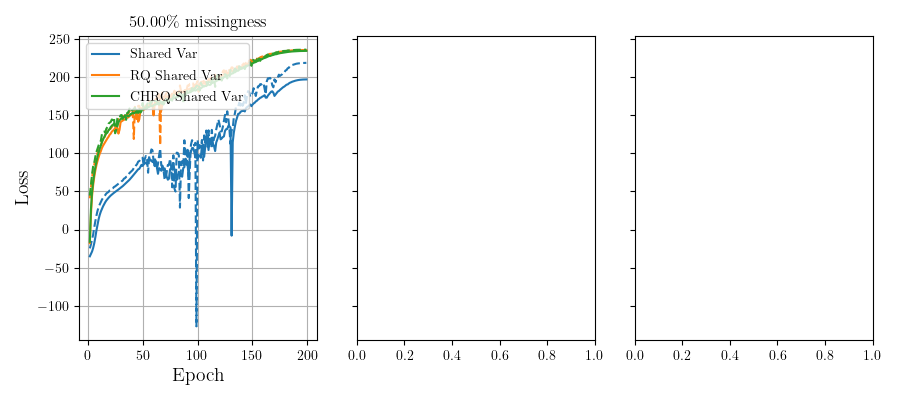

In [11]:
y_metrics = ('train_log_lik','val_log_lik',)
#             'val_log_lik_0',
#             'val_log_lik_1',
#             'val_log_lik_2',
#             'val_log_lik_3',
#             'val_log_lik_4',
#             'val_log_lik_5')
err_metrics = (None, None,)# None, None, None, None, None)
metric_labels = None

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(9, 4))
# axes = [axes]
axes = axes.flatten()
# gs = [1, 2, 3, 4, 5]
# gs = [1, 3, 5]
gs = [3]
for i, g in enumerate(gs):
    axes[i].set(title=f'{g/6*100:.2f}\% missingness')
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=y_metrics,  
                    err_keys=err_metrics,
                    metric_labels=metric_labels,
                    xlabel='Epoch',
                    ylabel='Loss', 
#                     ylim=(-1000, 1000),
                    colors_instead_styles=False)

    axes[i].legend(loc='upper left')

fig.tight_layout()